In [1]:
import sisl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
%matplotlib inline

# Spin Texture 
In this exercise, we learn how to calculate and plot spin-textures using ```sisl``` and ```SIESTA```, using buckled hexagonal bismuthene as an example.

## Exercise Overview
1. Create bismuthene geometry.
2. Generate ```SIESTA``` Hamiltonian.
3. Calculate the band structure.
4. Calculate the spin texture.

## Exercise

#### 1. Create the geometry in ``sisl`` and save it.
For this exercise, we model bismuthene in a buckled hexagonal phase. This crystal structure is similar to graphene, with two atoms per unit cell. However, the two sublattices form two parallel planes, separated by the buckling height $h$.
We use an in-plane lattice constant $a$ of $4.60\mathring{\textrm{A}}$ and buckling height $h$ of $1.62\mathring{\textrm{A}}$. The lattice constant for the orthogonal direction $c$ can be large, e.g. $40\mathring{\textrm{A}}$.

|Top view |Side View |
|:--------|:---------|
|<img src="img/Bi2D-BHex-c.png" alt="BHex-c" style="width: 400px;"/>|<img src="img/Bi2D-BHex-a.png" alt="BHex-a" style="width: 400px;"/>|

In [2]:
# Lattice constants
a = 4.60
c = 40.0
# Lattice vectors
a1 = a * np.asarray([1., 0., 0.])
a2 = a * np.asarray([-1./2, np.sqrt(3)/2, 0.])
a3 = c * np.asarray([0., 0., 1.])
# Atomic_positions
xyz = [
    0 * a1,                                 # Atom 1
    2./3 * a1 + 1./3 * a2 + [0., 0., 1.62]  # Atom 2
]
# Create geometry 
geom = sisl.Geometry([xyz],
                     sc=sisl.SuperCell([a1,a2,a3]),
                     atoms=sisl.Atom('Bi'))
geom.write('STRUC.fdf')

In [3]:
# Alternative solution using sisl.geom.honeycomb
# Create honeycomb
alat = 4.6
bond = alat / (1.5 ** 2 + 3. / 4) ** 0.5
geom = sisl.geom.honeycomb(bond, 'Bi')
# Shift atoms in one sublattice
geom.xyz[1, 2] += 1.62
geom.write('STRUC.fdf')

#### 2. Generate SIESTA Hamiltonian
A sample input file for ``SIESTA`` can be found in the *siesta_work* folder. We refer to the manual (/Docs/siesta.pdf) for the description of input parameters. The ``SIESTA`` Hamiltonian is required to compute the spin texture. ``SIESTA`` will store it if the flag ``CDF.Save``, ``SaveHS``, or ``TS.HS.Save`` is set to ```true``` in the input file.
```
    siesta Bi2D_BHex.fdf > Bi2D_BHex.out
```
We can check the output file to ensure that the calculation converged and no errors occurred.

_Notes:_
``SIESTA`` produces different output files depending on which flag was used to write the Hamiltonian. The ``SystemLabel.HSX`` file (create with ``SaveHS True``) does not contain all the information needed for the following steps. For this, we have to include in the work folder the files:
- ``SystemLabel.ORB_INDX`` for information on the Basis and auxiliary supercell,
- ``SystemLabel.EIG`` for the Fermi level,
- ``SystemLabel.XV`` or ``fdf``-file for the geometry.

#### 3 Bandstructure

We now use ```sisl``` to calculate the band structure along the $\mathrm{M}$-$\Gamma$-$\mathrm{K}$-$\mathrm{M}$ path, reading the ```SIESTA``` Hamiltonian (Bi2D_BHex.nc, Bi2D_BHex.HSX or Bi2D_BHex.TSHS). 

*Notes:*
- [seeK-path](https://www.materialscloud.org/work/tools/seekpath) can be used to find the k-point path in the Brillouin Zone.
- ```sisl``` can save the geometry in different file formats, the ```xsf``` format can be read by seeK-path
- seeK-path uses a standardized unit cell. The displayed k-points refer to the reciprocal cell corresponding to this standardized cell, not to the original one.

In [4]:
# Read the Hamiltonian from siesta output and create sisl.BandStructure
sile = sisl.get_sile('siesta_work/Bi2D_BHex.fdf')
H = sile.read_hamiltonian(geometry=sile.read_geometry())
EFermi = sile.read_fermi_level()

kpath = sisl.BandStructure(H, point=[[1./2, 0., 0.], [0., 0., 0.],
                                     [1./3, 1./3, 0.], [1./2, 0., 0.]],
                           division=301,
                           name=['M', r'$\Gamma$', 'K', 'M'])

info:0: SislInfo: Siesta basis information is read from /home/juijan/codes/TopoToolsSiesta/Tutorials/Solution/TI_02/siesta_work/Bi2D_BHex.ORB_INDX, the radial functions are not accessible.


In [5]:
# Calculate the bands
lk = kpath.lineark()
xtick, xtick_label = kpath.lineartick()
bands = kpath.eigh()
nk, nbands = bands.shape

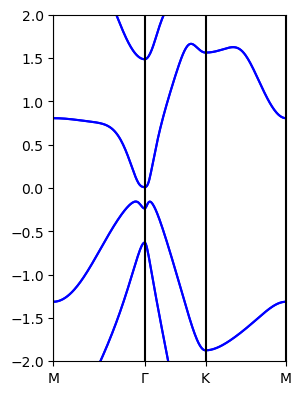

In [6]:
# Plot the band structure
fig, ax = plt.subplots(1, 1, figsize=(3,4.5))
ymin, ymax = (-2, 2)

for ibnd in range(nbands):
    ax.plot(lk, bands[:, ibnd], 'b')

ax.set_xlim(min(lk), max(lk))
ax.set_ylim(ymin, ymax)
ax.xaxis.set_ticks(xtick)
ax.set_xticklabels(xtick_label)
for tick in xtick:
    ax.plot([tick, tick], [ymin, ymax], 'k')
    

#### 4 Spin Texture

The spin moment of a state $\psi$ is given by the expectation value of the angular momentum operator $\langle\psi|\vec{\boldsymbol{\mathcal{S}}}|\psi\rangle$. It is a three-dimensional vector and we can express its components in terms of the Pauli matrices $\sigma_x$, $\sigma_y$, $\sigma_z$, and the overlap matrix $\mathbf{S}$ as

\begin{align}
    \boldsymbol{\mathcal S}_x &= \langle\psi| \sigma_x \mathbf{S} | \psi\rangle\\
    \boldsymbol{\mathcal S}_y &= \langle\psi| \sigma_y \mathbf{S} | \psi\rangle\\
    \boldsymbol{\mathcal S}_z &= \langle\psi| \sigma_z \mathbf{S} | \psi\rangle.
\end{align}

In a periodic system, we define the band structure as the dispersion of the eigenenergies in reciprocal space. Analogously, we define the spin texture as the dispersion of the spin moments of the eigenstates.

To calculate the spin texture along a path in reciprocal space we need to:

1. Calculate the eigenstates for a k-point

   We use the ``eigenstate`` routine of our  ``sisl.Hamiltonian`` to calculate all eigenstates at the given k-point. The routine returns an [``EigenstateElectron``](http://zerothi.github.io/sisl/docs/latest/api-generated/sisl.physics.EigenstateElectron.html) object, which contains all the eigenvectors and eigenvalues. This object also holds routines that enable the calculation of (projected) density of states, spin moments.
   ```
   H = sisl.Hamiltonian(...)
   eigs = H.eigenstate(k=[...])
   ```

2. Calculate the spin moments of the eigenstates

   The spin moments of the eigenstates can be calculated with the [``spin_moment``](http://zerothi.github.io/sisl/docs/latest/api-generated/sisl.physics.EigenstateElectron.html#sisl.physics.EigenstateElectron.spin_moment) routine.
   - All eigenstates at once:
   ```
   eigs.spin_moment()
   ```
   - A single state
   ```
   eigs[i].spin_moment()
   ```

3. Calculate the spin texture

   To calculate the full spin texture we loop over all k-points and repeatedly perform steps 1 and 2.
   ```
   kpath = sisl.BandStructure(H, ...)
   for ik, k in enumerate(kpath):
      # Perform steps 1 and 2
      ...
   ```
  *In exercise 2 we will explore alternative solutions to this problem.*

In [7]:
# Calculate the spin moments for all eigenstates along the k-path.
spin_moments = np.zeros((len(kpath), len(H), 3))
for ik, k in enumerate(kpath):
  eigs = H.eigenstate(k)
  spin_moments[ik] = eigs.spin_moment().real

A convenient way to visualize the spin texture is by coloring the bands according to the spin moment. The template below can be used to plot the spin texture. 

For reference on how to create multi-colored lines refer to the matplotlib [documentation](https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/multicolored_line.html).

In [8]:
def plot_spin_texture(kpath, bands, spin_moments):    
    lk = kpath.lineark()
    xtick, xtick_label = kpath.lineartick()    
    nk, nbands = bands.shape
    
    # Create a figure with three subplot one for each component of the spin moment
    fig, axes = plt.subplots(1, 3, figsize=(8, 4.5), dpi=400, sharex=True, sharey=True)

    # Set the range of z-values, which will determine the color.
    norm = plt.Normalize(-1, 1)

    # Iterate of the spin components
    for icomp, component in enumerate(['$S_x$', '$S_y$', '$S_z$']):
        # Iterate over all bands 
        for ibnd in range(nbands):
            # It is not possible to change the color of a line directly, so we create small 
            # line segements from one point on the x-axis to the next. These segments can 
            # then be colored individually.
            points = np.array([lk, bands[:, ibnd]]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            # Create a collection of the segments and specify a map that assigns colors 
            # to the segments according to the z-value
            lc = LineCollection(segments, cmap='coolwarm', norm=norm)
            # Set the z-values 
            lc.set_array(spin_moments[:, ibnd, icomp])             
            lc.set_linewidth(2)

            # Add the LineCollection to the subplot
            line = axes[icomp].add_collection(lc)
            
        axes[icomp].set_title(component)

    # All subplots share the same axis settings, so we can just adjust them once     
    ymin, ymax = (-2, 2)
    axes[0].set_xlim(min(lk), max(lk))
    axes[0].set_ylim(ymin, ymax) 
    axes[0].set_ylabel('Eigenspectrum [eV]')
    axes[0].xaxis.set_ticks(xtick)
    axes[0].set_xticklabels(xtick_label)

    for axis in axes:
        for tick in xtick:
            axis.plot([tick, tick], [ymin, ymax], 'k', linewidth=0.5)
    
    # Add a colorbar to the plot
    fig.colorbar(line, ax=axes.ravel().tolist())
    plt.show()

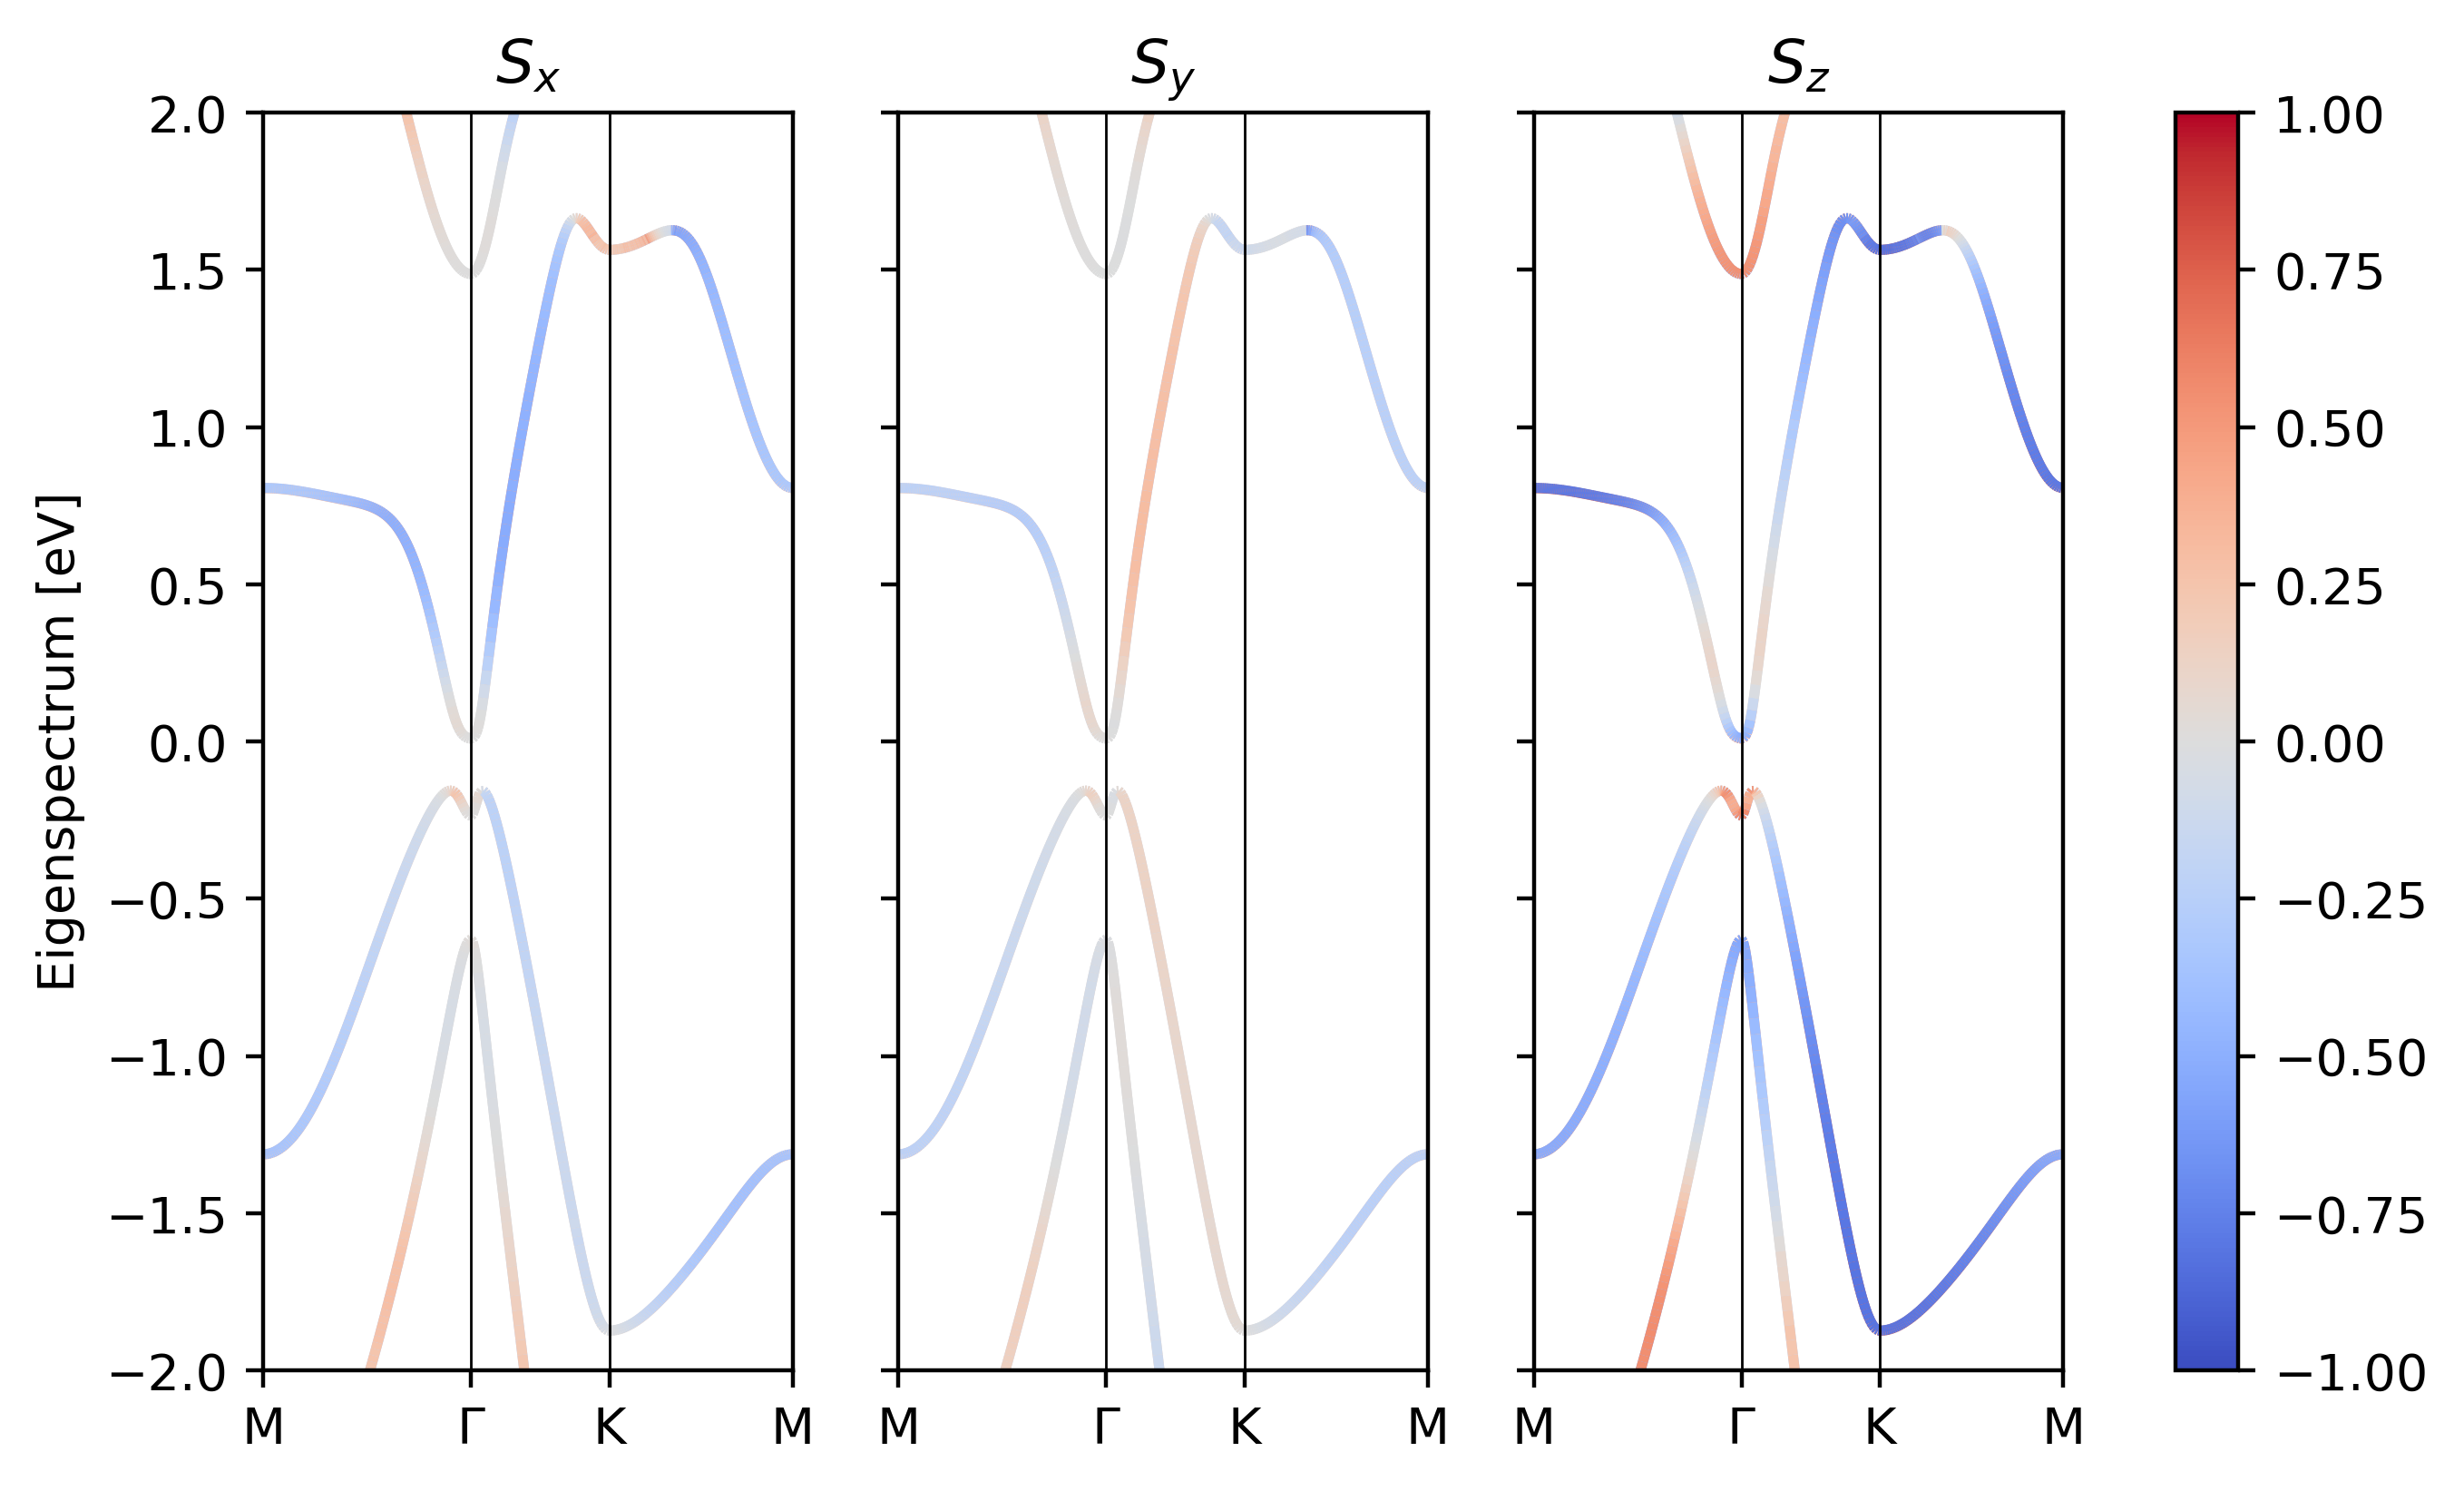

In [9]:
plot_spin_texture(kpath, bands, spin_moments)

## Exercise:
1. Note that every band is two-fold degenerate. How can we separately visualize the two degenerate bands?
   - What is the difference in spin textures of the two degenerate bands?
   - Why? 

   *Hint*: In which order are the bands are stored?

2. There is a very compact way to calculate the spin texture *and* band-structure eigenvalues in one call
   - when calling a method on a `sisl.BrillouinZone` object it allows for *more* keyword arguments, see [here](http://zerothi.github.io/sisl/docs/latest/api/physics.brillouinzone.html) under **Multiple quantities**
   - the computationally expensive part is calculating the eigenstates (values and vectors). So doing this
     once is preferred (especially for large structures). How can you wrap them in one command?

**Exercise 1**

Bands are sorted by energetic order. Hence, we can plot bands with even and odd indices separately to split all Karmer pairs.

First half of the bands (with even indices):

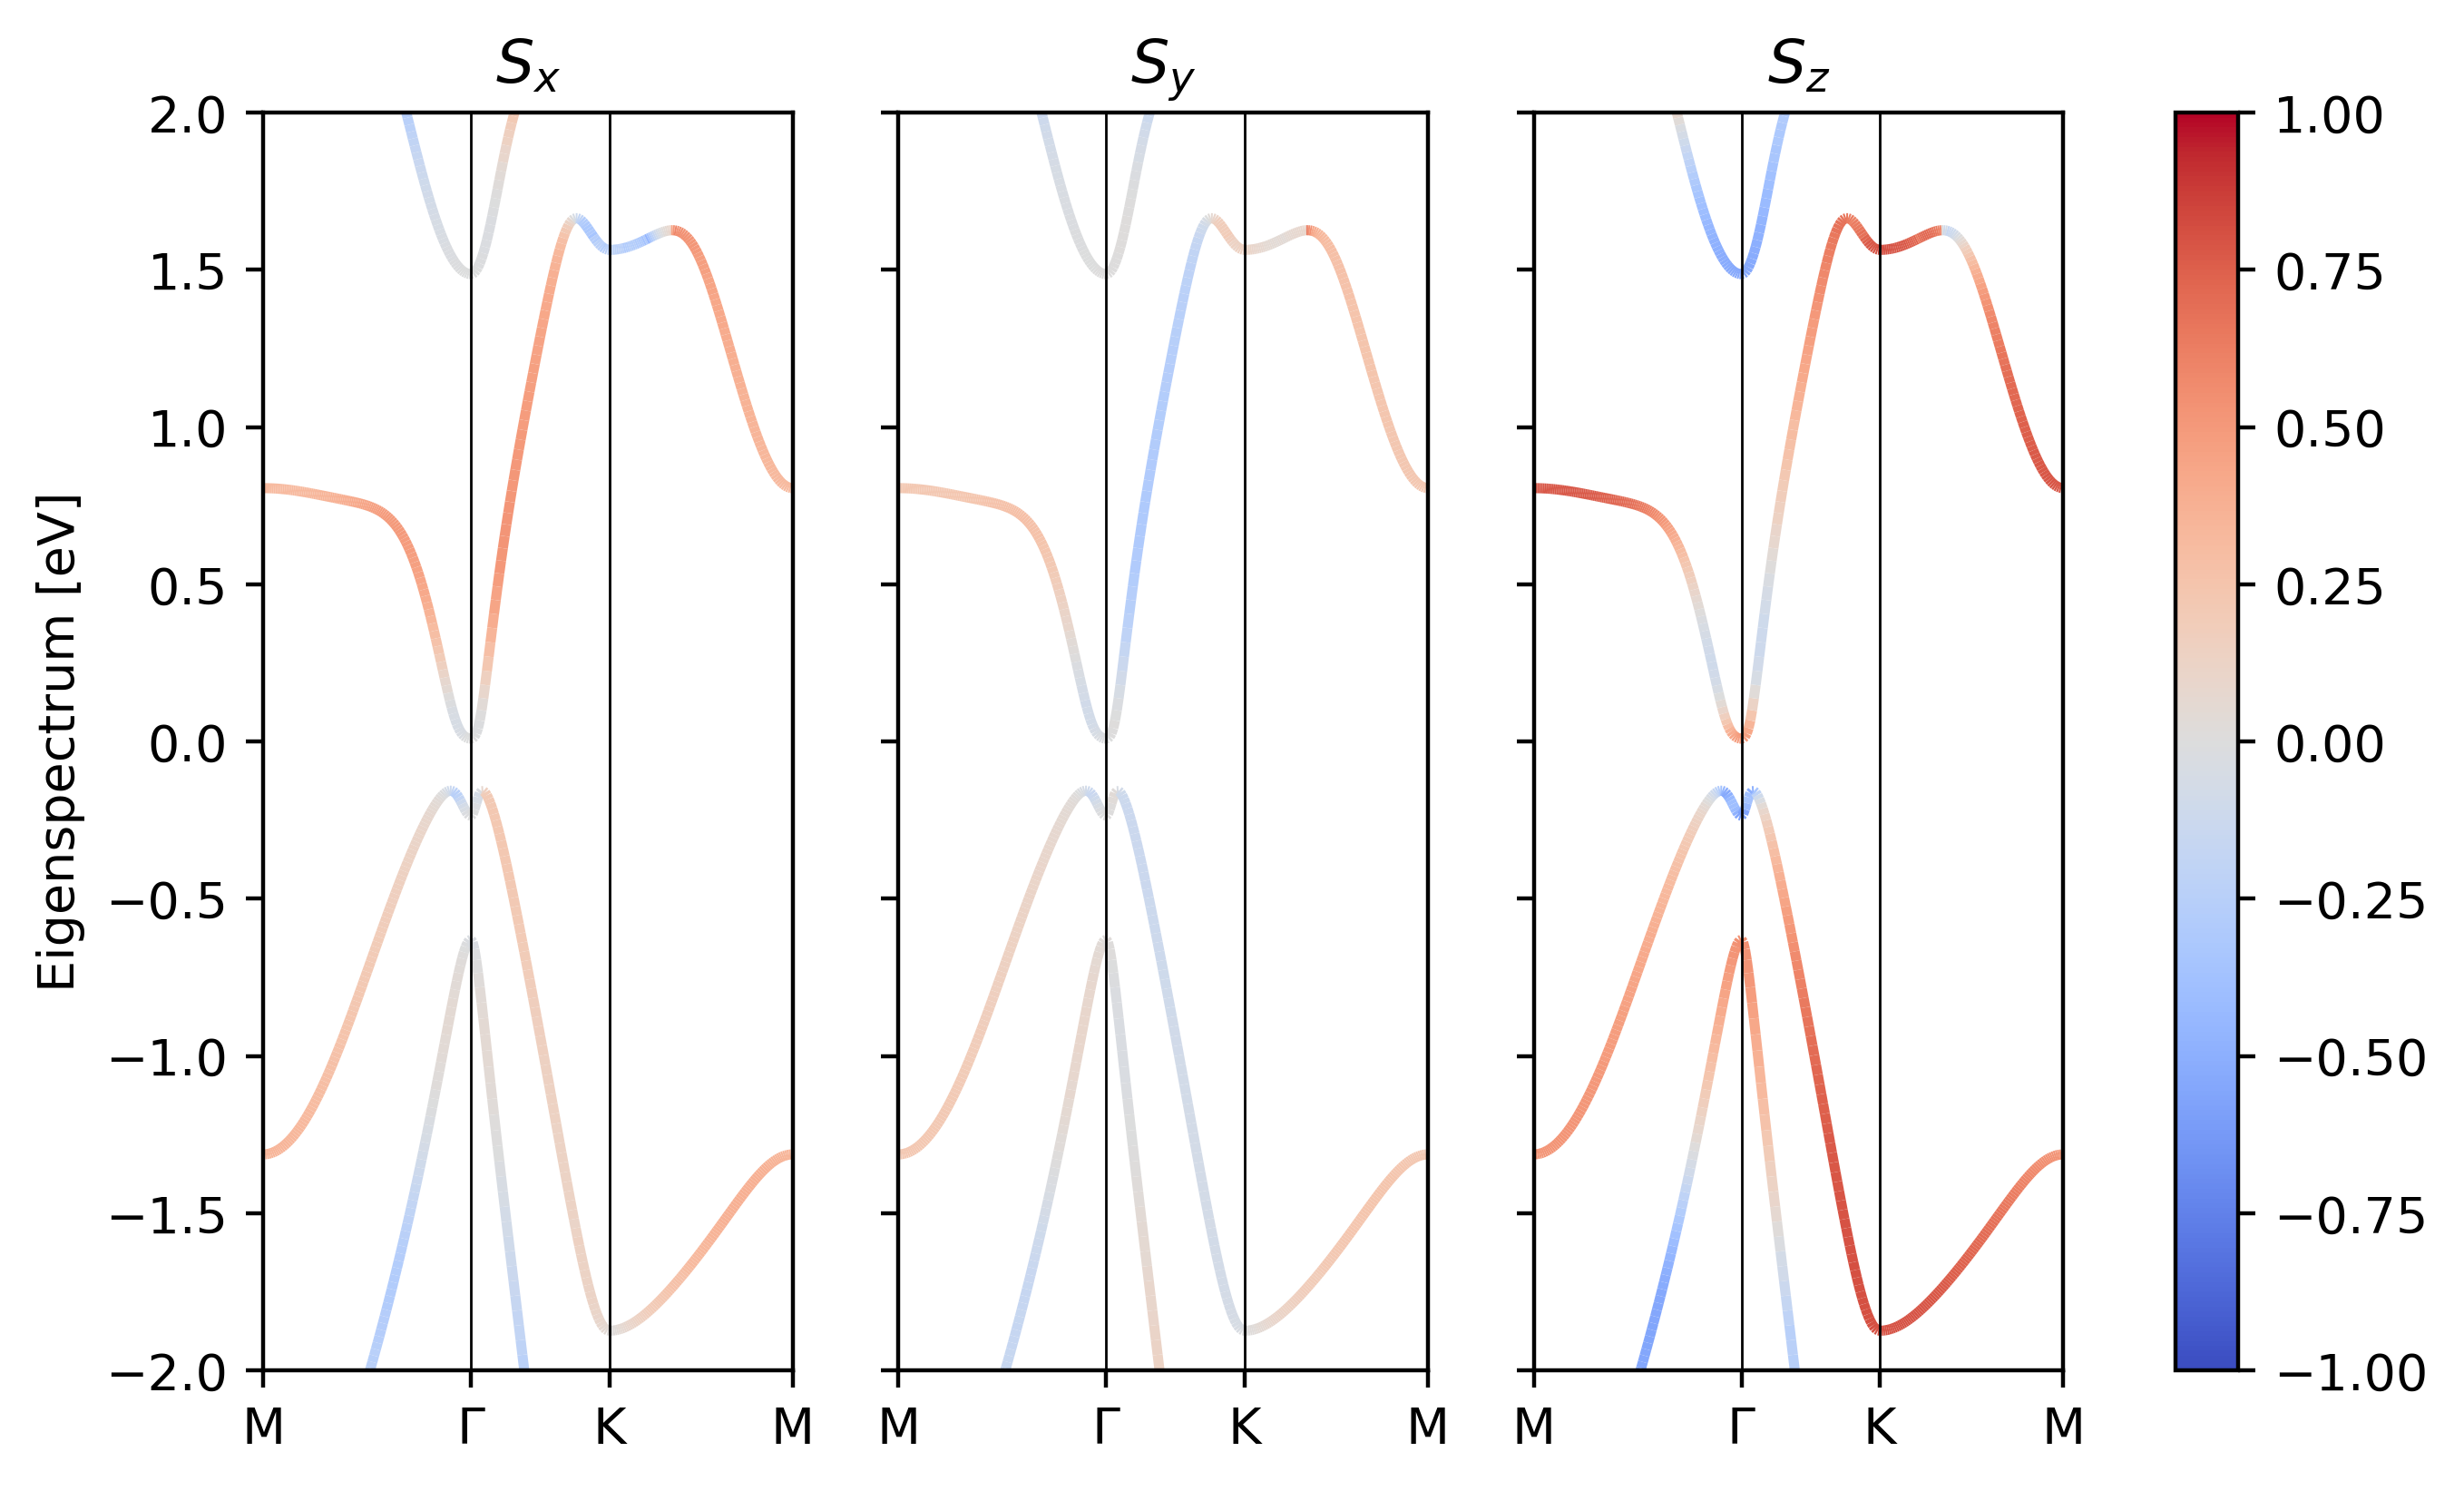

In [10]:
plot_spin_texture(kpath, bands[:,::2], spin_moments[:,::2])

Bands with odd indices:

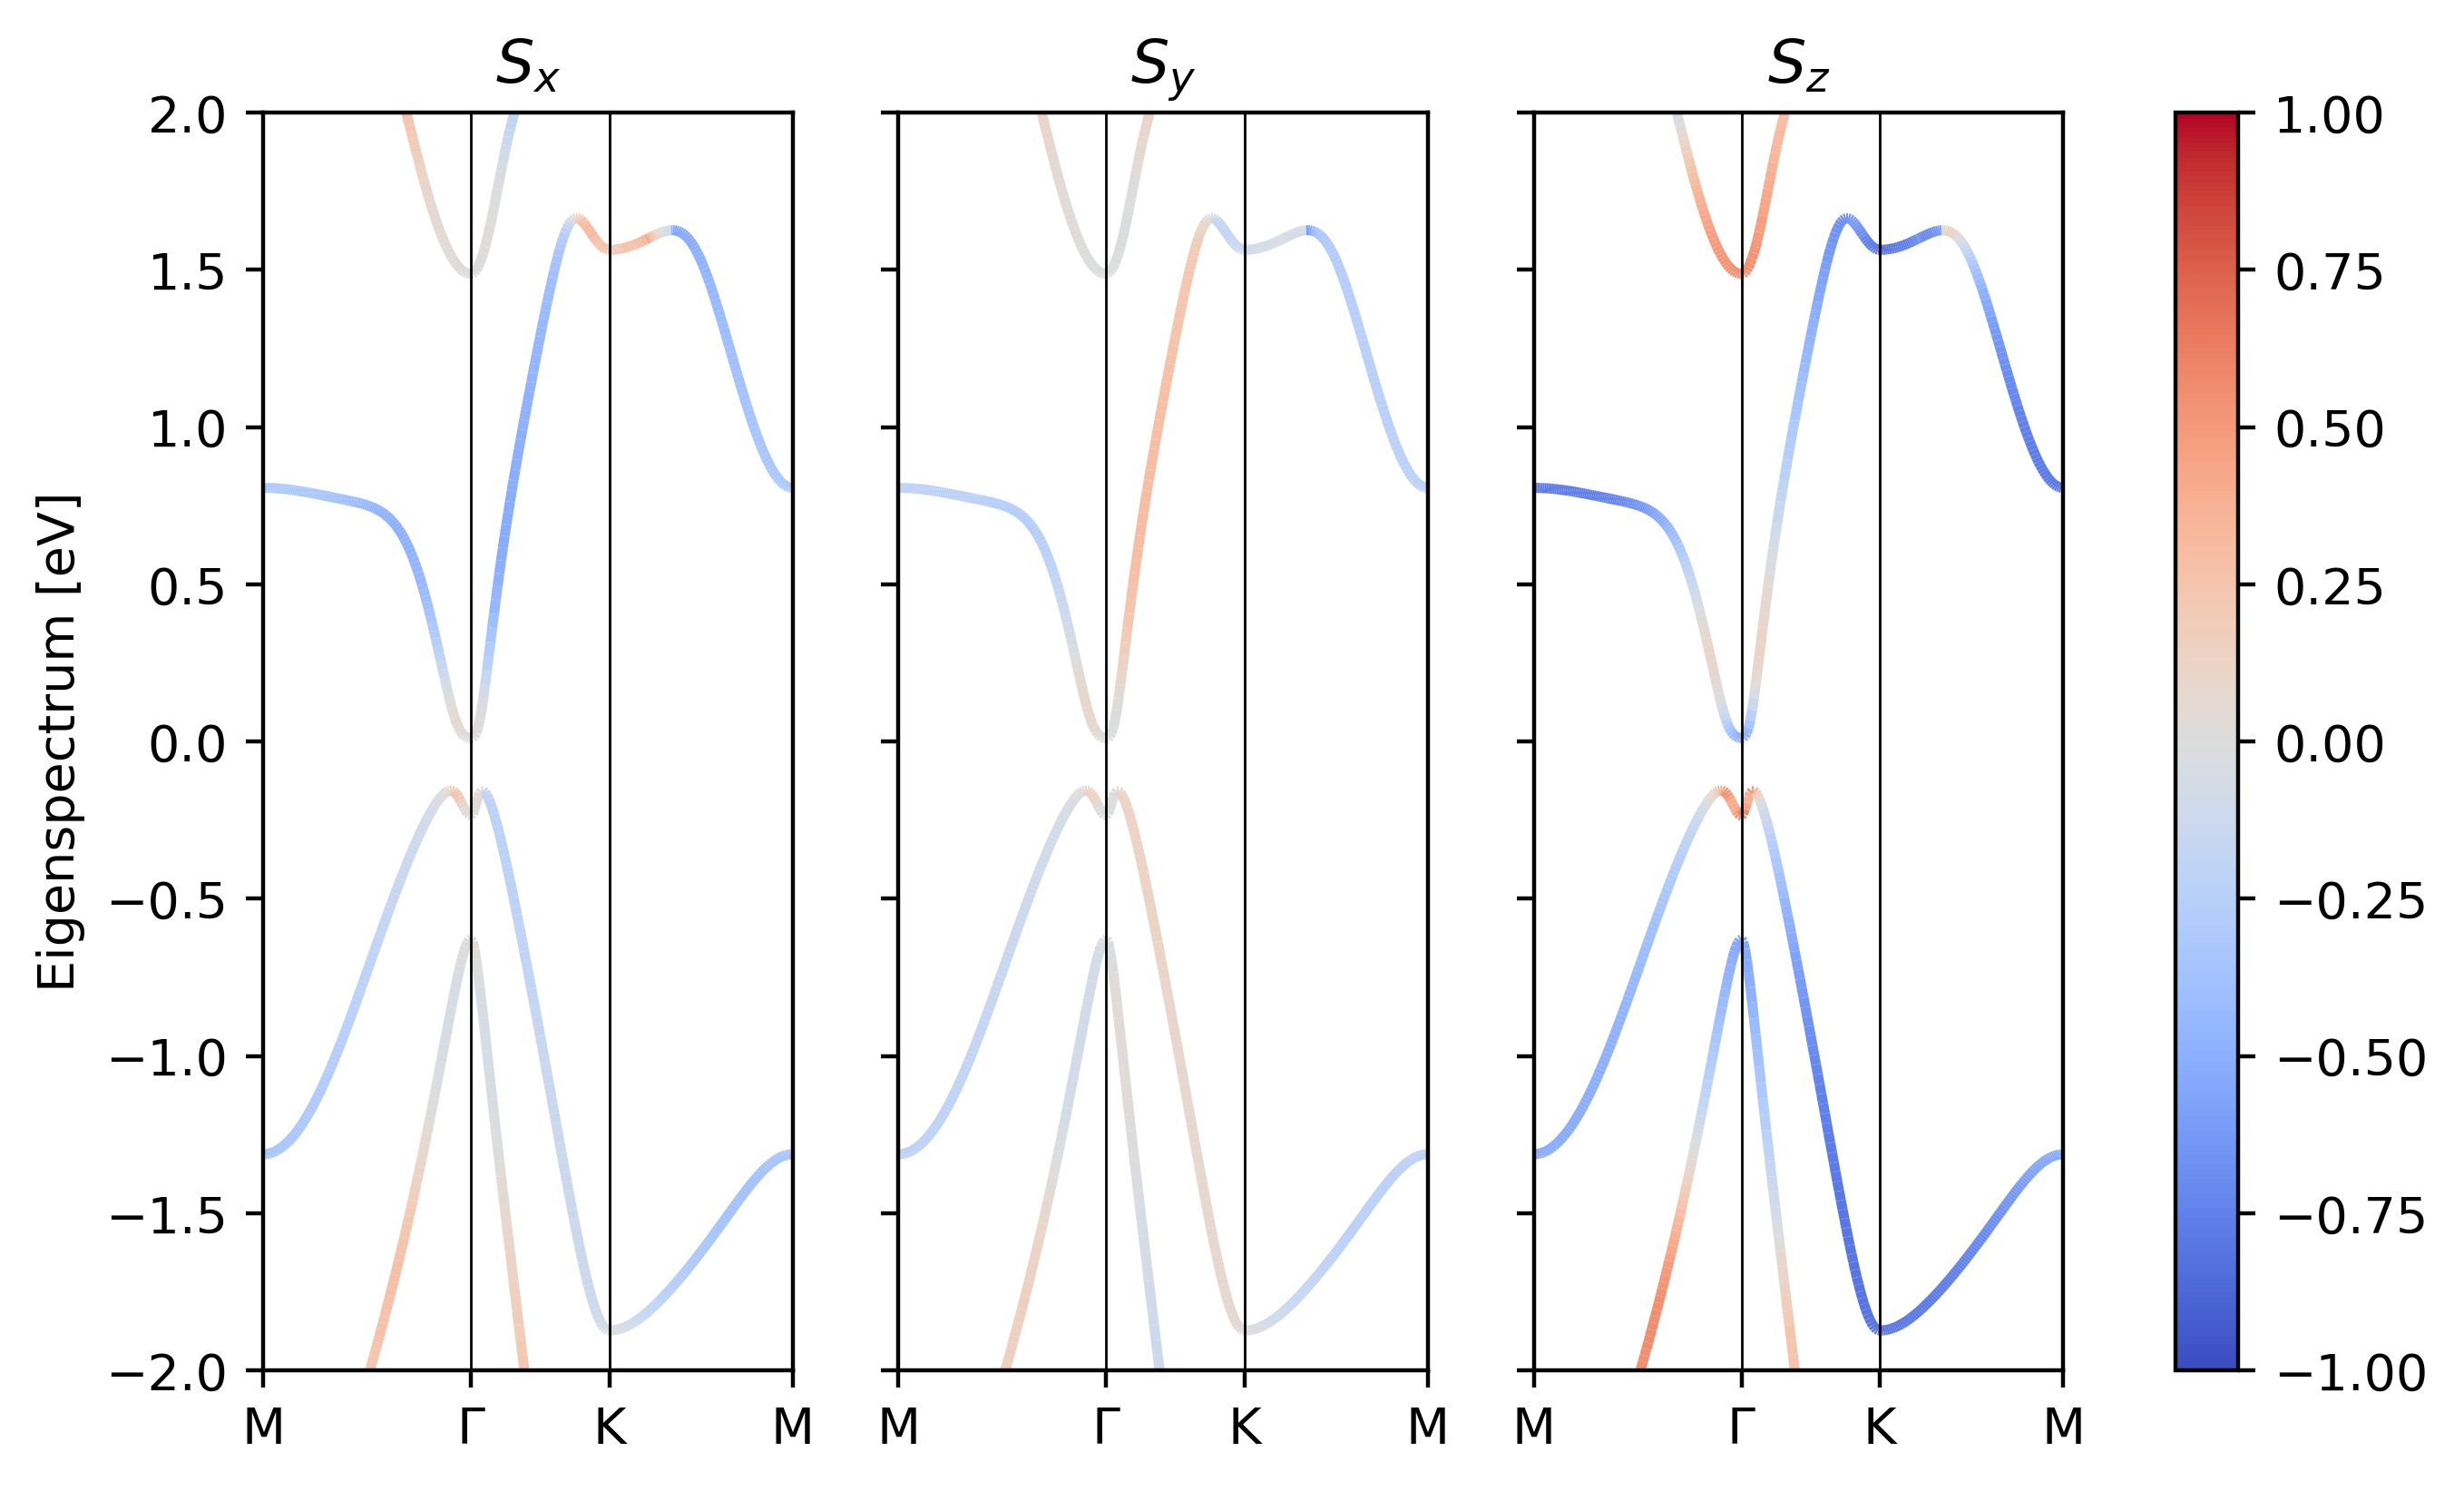

In [11]:
plot_spin_texture(kpath, bands[:,1::2], spin_moments[:,1::2])

The system is time-reversal invariant. Therefore, all states appear in degenerate Kramer pairs. The two states forming the Kramer pair are mapped onto each other by the time-reversal operator $T$. Since $T$ flips the spin of each state, the two states in every pair carry opposite spins, and are, hence, visualized with different colors.

We can see that the sum of the spin moments are indeed zero:

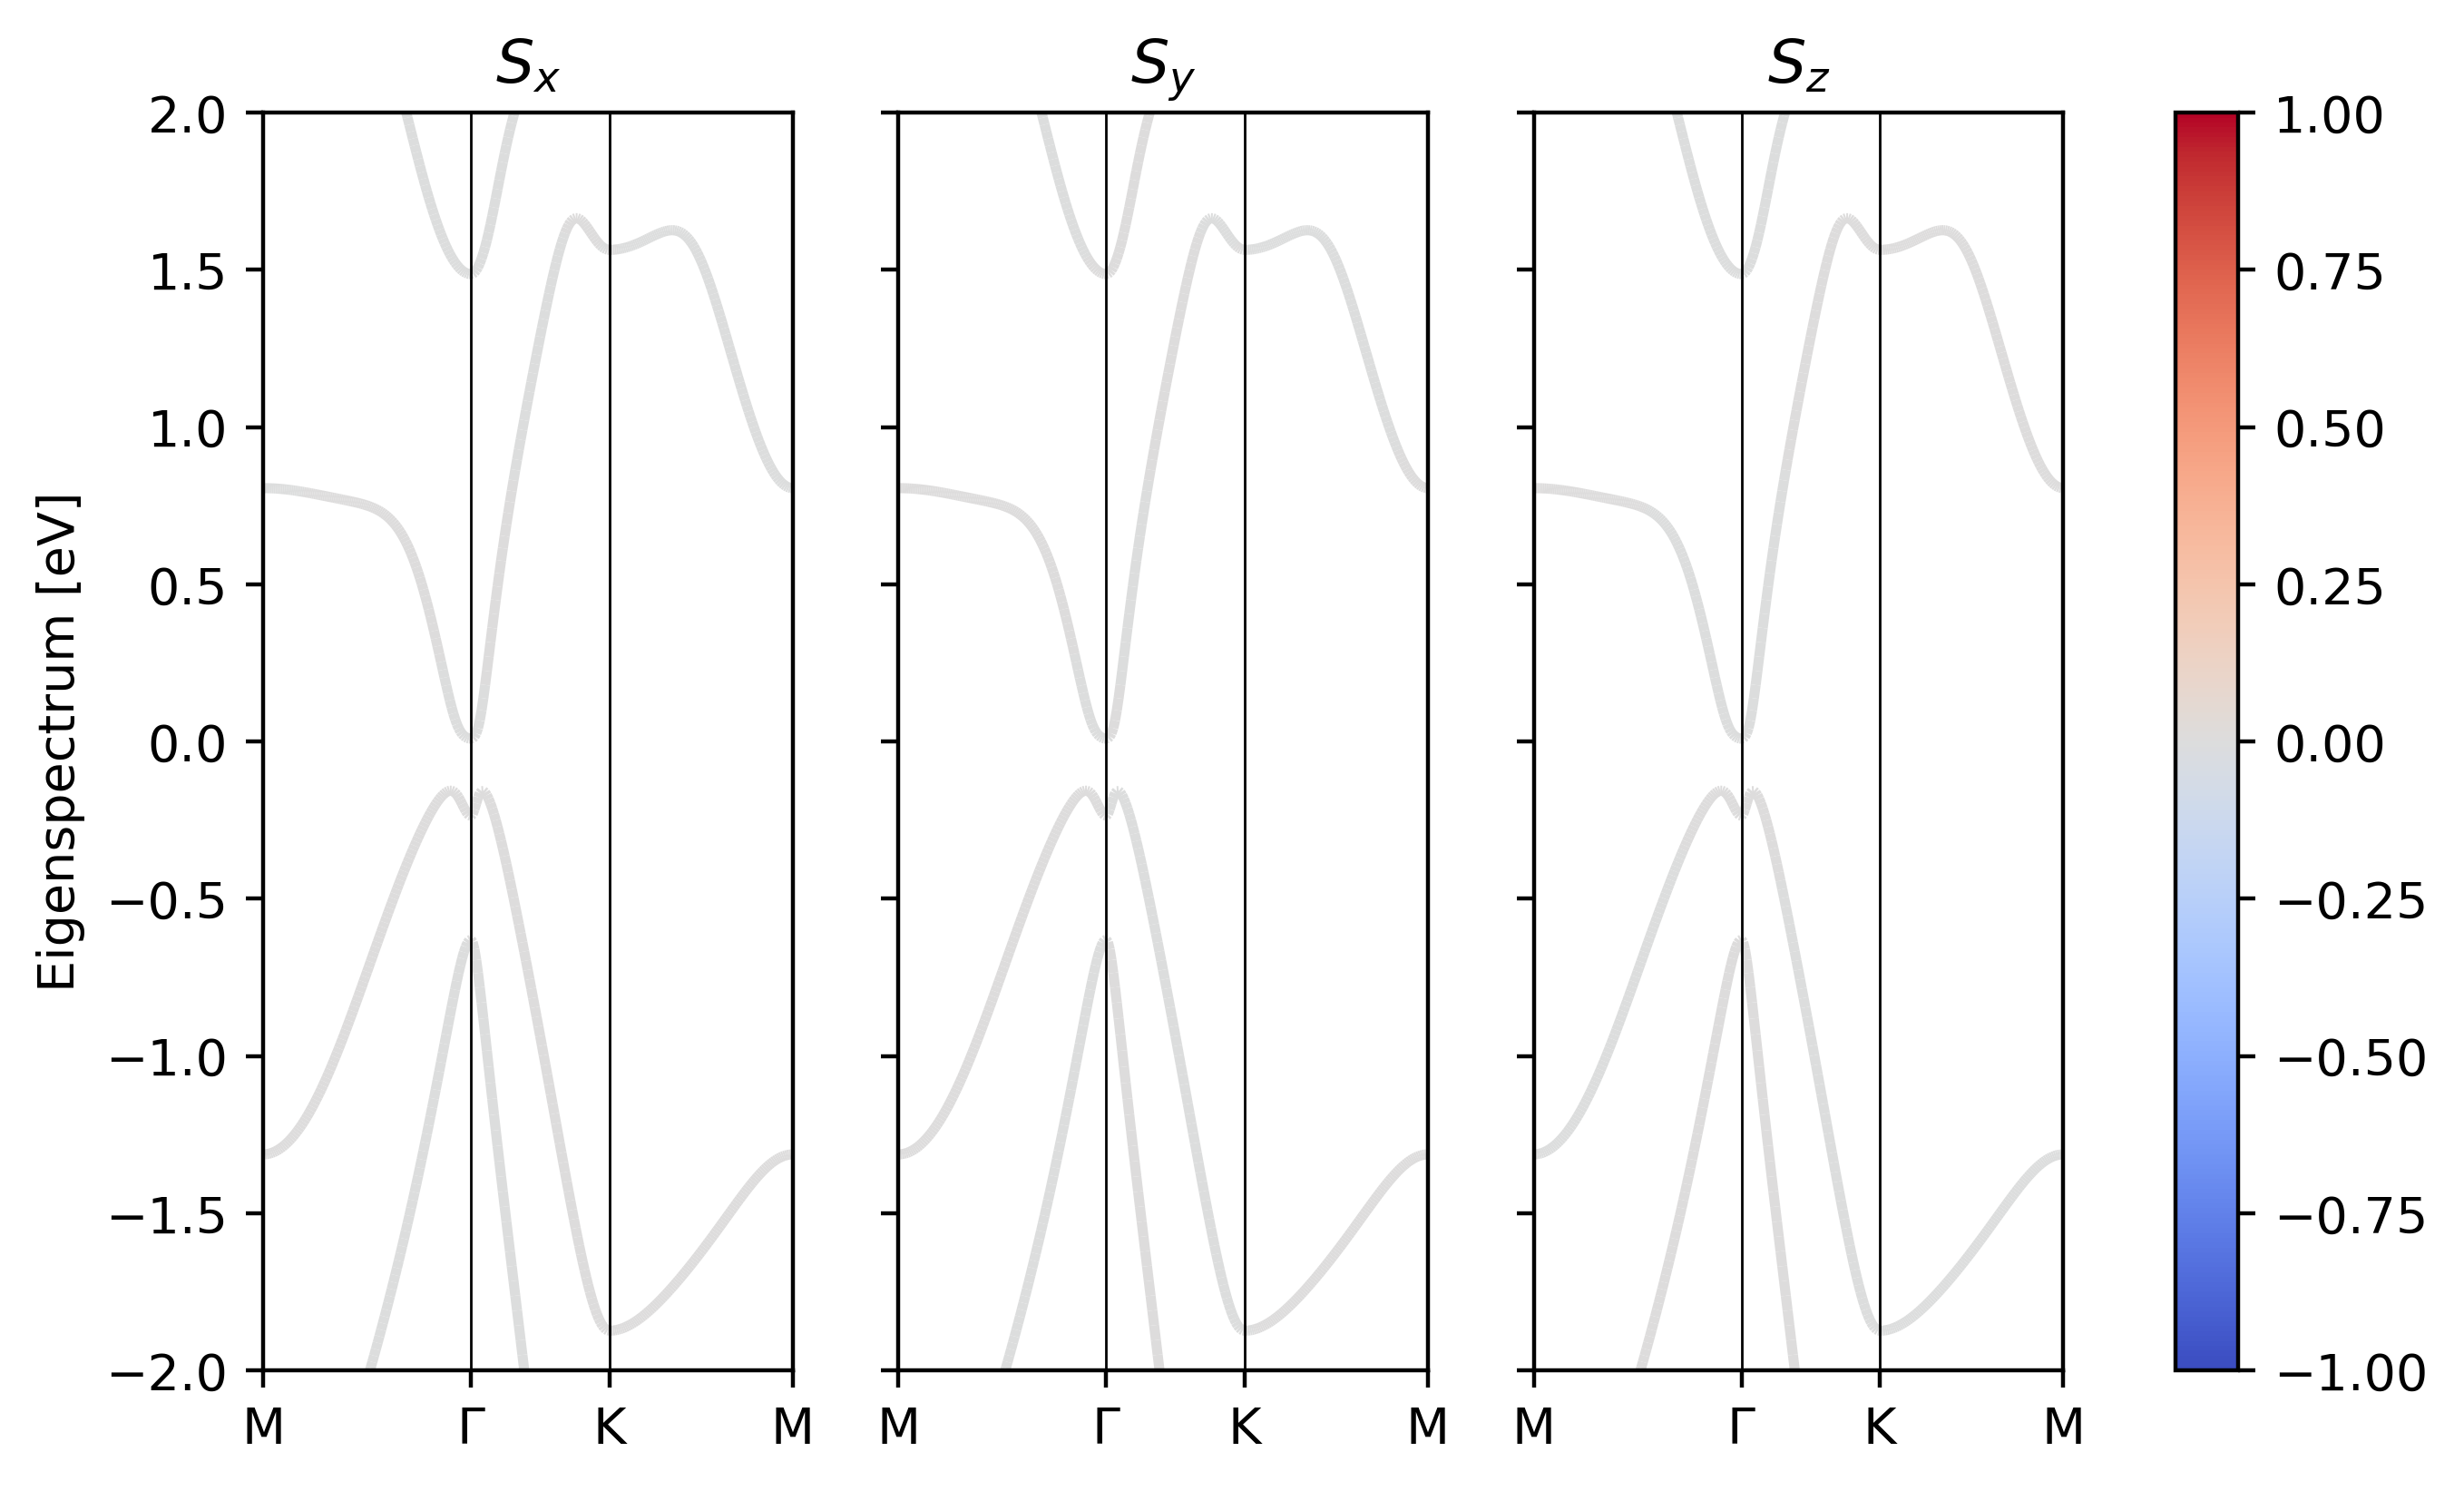

In [12]:
plot_spin_texture(kpath, bands[:,::2], spin_moments[:,0::2]+spin_moments[:,1::2])

**Exercise 2**

In [13]:
# Compact way to calculate the spin texture
def wrap(es):
    return es.eig, es.spin_moment()
bands, spin_moments2 = kpath.apply.array.renew(unzip=True).eigenstate(wrap=wrap)
# Check that the result is the same as above
print("The spin moments computed here are the same as the ones above? - ",
      np.allclose(spin_moments, spin_moments2))

The spin moments computed here are the same as the ones above? -  True


**Exercise 3**

In [14]:
def plot_spin_arrows(k_cart, bands, moments, lines=True):

    # Set up a plot with multiple suplots according to how many bands there are
    nbnds = bands.shape[1]
    nrows = int(np.sqrt(nbnds))
    ncols = (nbnds + nrows - 1) // nrows
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows),
                                sharex=True, sharey=True)

    # If there is just one row, matplotlib will return a 1D array.
    # For compatibility we make is two-dimensional
    if nrows == 1:
        axes = axes.reshape(1,-1)

    # Iterate over all bands
    for ibnd in range(nbnds):
        row = ibnd // ncols
        col = ibnd  % ncols
        axes[row,col].set_title(f'$\langle E \\rangle$={np.mean(bands[:,ibnd]):.3f} eV', fontsize=18)


        # (1) Plot the path as a line
        if lines:
            axes[row,col].plot(
                k_cart[:,0], k_cart[:,1],
                color='black', linewidth=1)

        # (2) Indicate the out-of-plane moment as dots with varying point size
        #     Additionally we use color to mark wether the moment point into or out of the plane
        def color(x):
            c = np.empty_like(x, dtype=object)
            c[np.where(x < 0)] = "tab:blue"
            c[np.where(x == 0)] = "black"
            c[np.where(0 < x)] = "tab:red"
            return c
        
        axes[row,col].scatter(
            k_cart[:,0], k_cart[:,1],
            s=np.abs(moments[:, ibnd, 2])*100,
            c=color(moments[:,ibnd, 2]),
            label="($S_x$,$S_y$) [arb. units]"
            )#, color='black', linewidth=2)

        # (3) Indicate the in-plane moments as arrows
        axes[row,col].quiver(
            k_cart[:,0], k_cart[:,1],
            moments[:, ibnd, 0],moments[:, ibnd, 1],
            pivot='tail',
            scale=4,
            color="tab:orange"
            )

    # All subplots share the same axis settings, so we can just them once
    axrange = (1.1*np.min(k_cart), 1.1*np.max(k_cart))
    axes[0,0].set(xlim=axrange, ylim=axrange)
    for ax in axes.ravel():
        ax.set(aspect=1)


    fig.supxlabel('$k_x$ [1/Å]', fontsize=18)
    fig.supylabel('$k_y$ [1/Å]', fontsize=18)
    plt.show()

In [15]:
# Create a circle in k space 
kcircle = sisl.BandStructure.param_circle(H, kR=0.1, origin=[0.0, 0.0, 0.0], normal=[0.0, 0.0, 1.0], N_or_dk=25, loop=True)

# Calculate band energies and spin moments
def wrap(es):
    return es.eig, es.spin_moment()
bands, moments = kcircle.apply.array.renew(unzip=True).eigenstate(wrap=wrap)

In [16]:
# Restrict to a small energy range
erange = (-1,1)
selected_idx = np.where(np.logical_and(np.mean(bands, 0) > erange[0], np.mean(bands, 0) < erange[1]))[0]
selected_bands = bands[:,selected_idx]
selected_moments = moments[:,selected_idx]

# k point in cartesian coordinates
k_cart = kcircle.k @ geom.rcell

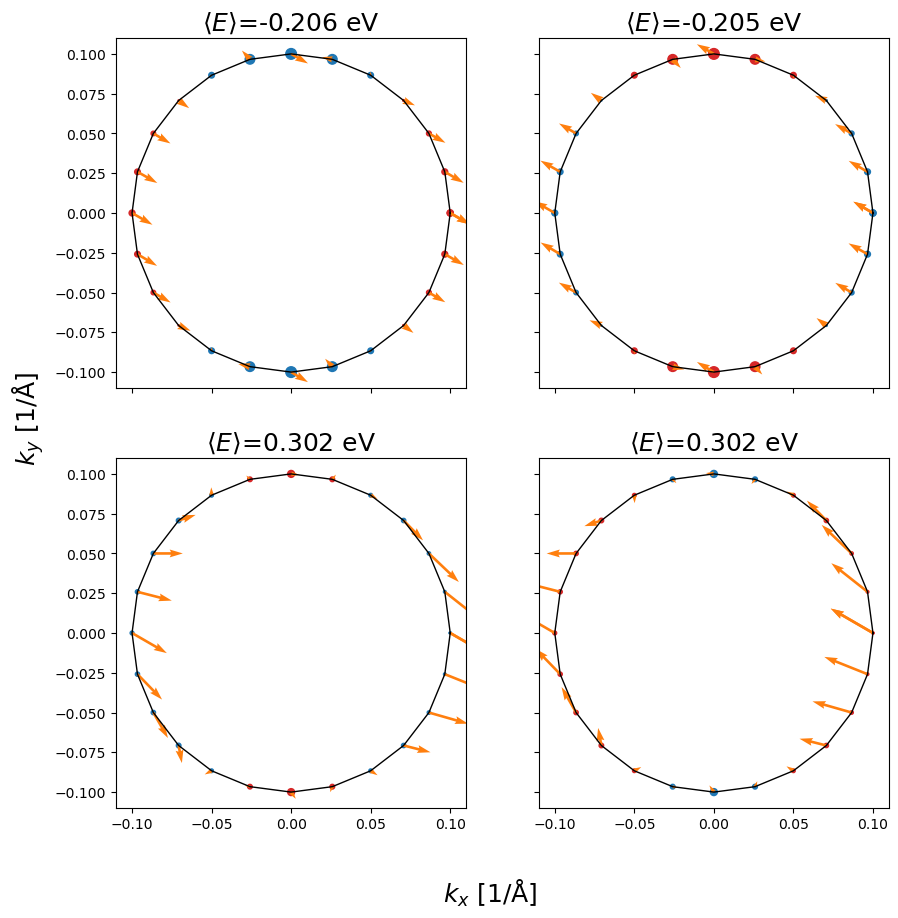

In [17]:
plot_spin_arrows(k_cart, selected_bands, selected_moments)

In [18]:
kgrid = sisl.MonkhorstPack(H, [6,6,1], trs=False)
k_cart = kgrid.k @ geom.rcell

# Calculate band energies and spin moments
def wrap(es):
    return es.eig, es.spin_moment()
bands, moments = kgrid.apply.array.renew(unzip=True).eigenstate(wrap=wrap)

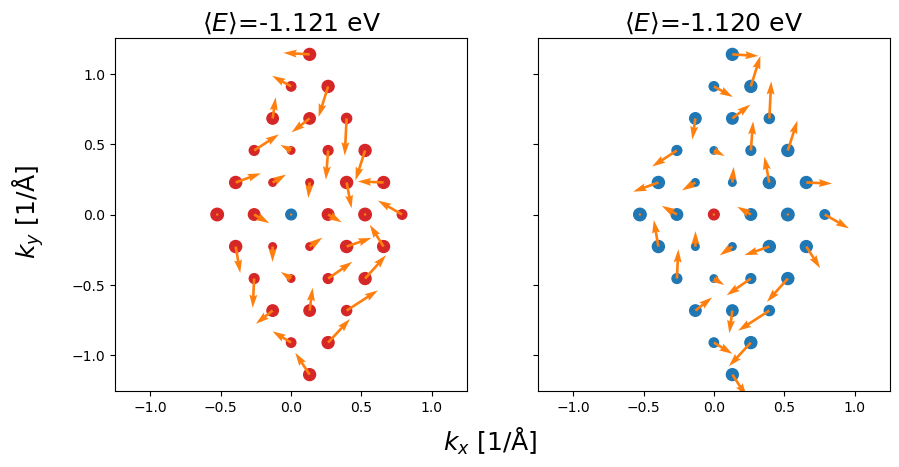

In [19]:
plot_spin_arrows(k_cart, bands[:,28:30], moments[:,28:30], lines=False)